In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import pandas as pd
%matplotlib inline
import scipy.sparse

Le but de ce TP est d’implementer un coût softmax, pour pouvoir appliquer la régression logistique à des problèmes de classification multiclasse. Dans ce contexte, la modélisation de la probabilité d’appartenance à une classe est donnée par :

$p(λ_k|x) = exp(x^t>w_k) / ∑^C_{j=1} exp(x^t>w_j )$

où x ∈ $R^{(d+1)}$ (vecteur augmenté), C est le nombre de classes et $w_k$ ∈ $R^{(d+1)}$. On appelle cette fonction, la fonction softmax.

En considérant que $y{i,j} = p(λ_j |x_i)$ est la ”vraie” probabilité d’appartenance à la classe $λ_j$ pour l’instance $x_i$, la fonction de coût s’écrit :

$L(y_i, ŷ_i) = −∑^C_{j=1}y_{i,j}log(ŷ{i,j} )$

où $ŷ{i,j}$ est modélisé par la fonction softmax ci-dessus.

Vous allez implémenter dans ce TP, un modèle de régression softmax régularisé appris tel que :

$min_W 1/n ∑^n_{i=1}L(yi, ŷi) + λ/2 ∑^C_{k=1}‖wk‖^2$

où W est une matrice (d + 1) × C contenant l’ensemble des $w_k$, ∀k = 1..C

1. Commencez par charger les données du dataset digits de Scikit-learn :

In [31]:
n_class = 10
X, y = load_digits(n_class=n_class , return_X_y=True)

In [32]:
print(np.shape(X))

(1797, 64)


Donnez en quelques lignes une description de ces données et de la tâche sous-jacente. Précisez à quoi correspondent les caractéristiques

Os dados representam uma matriz 8x8 com a imagem de de um digito numerico de 0 a 9. Os valores de X variam de 0 a 1 representando a escala de cinza do digito, sendo zero um espaço vazio e 1 um pixel onde ha um traço bem definido.

2. Implémentez les fonctions permettant :
- de générer les encodages one-hot d’un ensemble de données à partir de leurs étiquettes.
- d’évaluer une fonction softmax étant donné un z = x>w
- d’estimer les ˆyi,j = p(λj |xi), ∀j = 1..C, ∀xi ∈ X et étant donné W.

In [33]:
def onehot_encoding(y, n_class):
    n = y.shape[0]
    y_one = np.zeros((n, n_class))
    for i in range(n):
        y_one[i, y[i]] = 1
    return y_one

def softmax(z):
    z -= np.max(z) # computational trick for numerical stability
    sm = np.exp(z)/np.sum(np.exp(z))
    return sm

def get_prob_pred(X, W):
    z =  np.dot(X,W)
    probs = softmax(z)
    preds = np.argmax(probs)
    return probs, preds

In [34]:
n, d = X.shape
X_plus = np.concatenate((X, np.ones((n, 1))), axis =1)
w = np.zeros([X_plus.shape[1],len(np.unique(y))])
prob_test, preds = get_prob_pred(X_plus, w)
print(preds)

0


In [35]:
ytest = onehot_encoding(y, n_class)
print(np.shape(y))

(1797,)


In [36]:
print(np.shape(ytest))

(1797, 10)


3. Calculez analytiquement l’expression du gradient de la fonction de coût par rapport à W.

4. Implémentez maintenant une fonction qui calcule la fonction de coût et le gradient.

In [37]:
def get_loss_grad(W, X, y, lam , n_class):
    n = X.shape[0]
    y_mat = onehot_encoding(y, n_class) # convert the integer class coding into a one-hot representation
    scores = X @ W # compute raw class scores given our input and current weights
    prob = softmax(scores) # perform a softmax on these scores to get their probabilities
    loss = (-1 / n) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) 
    grad = (-1 / n) * np.dot(X.T,(y_mat - prob)) + lam*w 
    return loss , grad

5. Implémentez une descente de gradient avec backtracking pour optimiser les paramètres W.

In [49]:
def logreg_descent(X, y, learning_rate =1e-3, max_iter =1000):
    w = np.zeros([X.shape[1],len(np.unique(y))])
    lam = 1
    iterations = 10000
    tol = 1e-3
    learningRate = 1e-5
    losses = []
    for i in range(0,iterations):
        loss,grad = get_loss_grad(w,X,y,lam,n_class)
        losses.append(loss)

         # Convergence seuil
        if i > 0 and abs(losses[i] - losses[i-1]) < tol:
            print(f"Convergence at {i}th step")
            return loss, losses[:i+1] 
        
        w = w - (learningRate * grad)

    return loss, losses

In [50]:
w = np.zeros([X.shape[1],len(np.unique(y))])
lam = 1
iterations = 10000
learningRate = 1e-5
losses = []
for i in range(0,iterations):
    loss,grad = get_loss_grad(w,X,y,lam,n_class)
    losses.append(loss)
    w = w - (learningRate * grad)
print(loss)

13.762678194240944


6. Visualisez l’évolution de la fonction de coût en fonction du nombre d’itérations et analysez ce que vous observez.

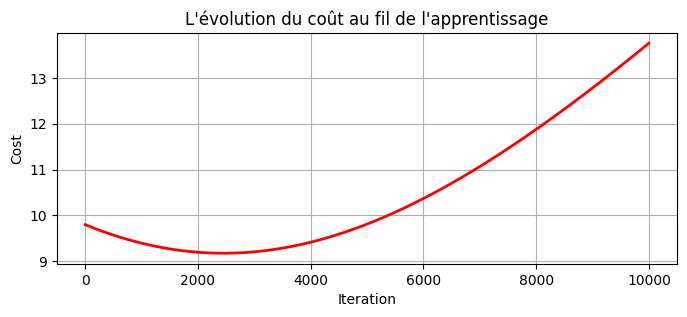

In [51]:
plt.figure(figsize=(8, 3))
plt.plot(range(len(losses)), losses, color="red", linewidth=2)
plt.title("L'évolution du coût au fil de l'apprentissage")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

7. Proposez un protocole d’évaluation de votre méthode et commentez les résultats obtenus.

In [43]:
def getAccuracy(X,Y):
    prob,prede = get_prob_pred(X,w)
    accuracy = sum(prede == Y)/(float(len(Y)))
    return accuracy

print('Training Accuracy: ', getAccuracy(X,y))
# print('Test Accuracy: ', getAccuracy(testX,testY))



Training Accuracy:  0.0
